# Training Quantum Kernels

Here we train a quantum kernel on on our pulsar dataset using Quantum Kernel Alignment (QKA). QKA is a technique that iteratively adapts a parametrized quantum kernel to a dataset while converging to the maximum SVM margin. More information about QKA can be found in the preprint, “Covariant quantum kernels for data with group structure.”

In [1]:
# External imports
from pylab import cm
import pandas as pd
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.providers.aer import AerSimulator
from qiskit.visualization import circuit_drawer
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_machine_learning.algorithms import QSVC

from dataset import read_dataset, divide_dataset, balance_dataset

In [2]:
class QKTCallback:
    """Callback wrapper class."""

    def __init__(self) -> None:
        self._data = [[] for i in range(5)]

    def callback(self, x0, x1=None, x2=None, x3=None, x4=None):
        """
        Args:
            x0: number of function evaluations
            x1: the parameters
            x2: the function value
            x3: the stepsize
            x4: whether the step was accepted
        """
        self._data[0].append(x0)
        self._data[1].append(x1)
        self._data[2].append(x2)
        self._data[3].append(x3)
        self._data[4].append(x4)

    def get_callback_data(self):
        return self._data

    def clear_callback_data(self):
        self._data = [[] for i in range(5)]

# Data

As usual we use the HTRU2 data for pulsar. We load it and extract a small subset of the data here.


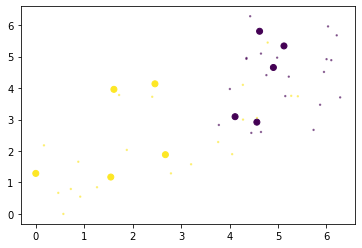

In [3]:
# read the data
dataset = read_dataset()

# extract a balances subset containing a limited number of points
npts = 50
dataset = balance_dataset(dataset, npts)

# only consider a subset of the features
features = [0,1,4]
nfeatures = len(features)
dataset.features = dataset.features[:,features]

# normalize the data between 0 and 2pi
dataset.features -= dataset.features.min(0)
dataset.features /= dataset.features.max(0)
dataset.features *= 2*np.pi


# divide the dataset in train/test
train_dataset, test_dataset = divide_dataset(dataset, shuffle=False)

# plot the data
plt.scatter(train_dataset.features[:,0],train_dataset.features[:,1],c=train_dataset.labels,s=2,alpha=0.5)
plt.scatter(test_dataset.features[:,0],test_dataset.features[:,1],c=test_dataset.labels)

# Define the Quantum Feature Map

As for the nornal kernel method we need to define a quantum feature map that transforms the classical data into a quantum circuit. At the difference of the previous case, the map here contains at least one trainable parameter

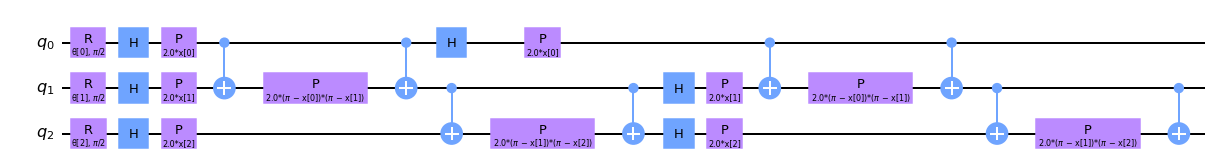

In [4]:
# Create a rotational layer to train. We will rotate each qubit the same amount.
user_params = ParameterVector("θ", 3)
fm0 = QuantumCircuit(nfeatures)
fm0.ry(user_params[0], 0)
fm0.ry(user_params[1], 1)
fm0.ry(user_params[2], 2)

# Use ZZFeatureMap to represent input data
fm1 = ZZFeatureMap(feature_dimension=nfeatures, reps=2, entanglement="linear")

# Create the feature map, composed of our two circuits
fm = fm0.compose(fm1)

fm.decompose().draw(output="mpl")
# print(f"Trainable parameters: {user_params}")

# Quantum Kernel and kernel trainer

To train the quantum kernel, we need a QuantumKernel (holds the feature map and its parameters) and QuantumKernelTrainer (manages the training process).

We will train using the Quantum Kernel Alignment technique by selecting the kernel loss function, SVCLoss, as input to the QuantumKernelTrainer. Since this is a Qiskit-supported loss, we can use the string, "svc_loss"; however, note that default settings are used when passing the loss as a string. For custom settings, instantiate explicitly with the desired options, and pass the KernelLoss object to the QuantumKernelTrainer.

We will select SPSA as the optimizer and initialize the trainable parameter with the initial_point argument. Note: The length of the list passed as the initial_point argument must equal the number of trainable parameters in the feature map.


In [5]:
# Use the qasm simulator backend
backend = AerSimulator(method="statevector")

# Instantiate quantum kernel
quant_kernel = QuantumKernel(fm, user_parameters=user_params, quantum_instance=backend)

# Set up the optimizer
cb_qkt = QKTCallback()
spsa_opt = SPSA(maxiter=10, callback=cb_qkt.callback, learning_rate=0.05, perturbation=0.05)

# Instantiate a quantum kernel trainer.
qkt = QuantumKernelTrainer(
    quantum_kernel=quant_kernel, loss="svc_loss", optimizer=spsa_opt, initial_point=[np.pi / 2]*3
)

# Train the kernel

To train the quantum kernel on the dataset (samples and labels), we call the fit method of QuantumKernelTrainer.

The output of QuantumKernelTrainer.fit is a QuantumKernelTrainerResult object. The results object contains the following class fields: - optimal_parameters: A dictionary containing {parameter: optimal value} pairs - optimal_point: The optimal parameter value found in training - optimal_value: The value of the loss function at the optimal point - optimizer_evals: The number of evaluations performed by the optimizer - optimizer_time: The amount of time taken to perform optimization - quantum_kernel: A QuantumKernel object with optimal values bound to the feature map

In [6]:
# Train the kernel using QKT directly
qka_results = qkt.fit(train_dataset.features, train_dataset.labels)
optimized_kernel = qka_results.quantum_kernel
print(qka_results)

{   'optimal_parameters': {   ParameterVectorElement(θ[0]): 2.3053828750925636,
                              ParameterVectorElement(θ[1]): 1.5658021363426382,
                              ParameterVectorElement(θ[2]): 1.433225939754882},
    'optimal_point': array([2.30538288, 1.56580214, 1.43322594]),
    'optimal_value': 19.98147509697668,
    'optimizer_evals': 30,
    'optimizer_time': None,
    'quantum_kernel': <qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x7ff82ae30550>}


# Fit and test the model

We can pass the trained quantum kernel to a machine learning model, then fit the model and test on new data. Here, we will use Qiskit’s QSVC for classification.

In [7]:
# Use QSVC for classification
qsvc = QSVC(quantum_kernel=optimized_kernel)

# Fit the QSVC
qsvc.fit(train_dataset.features, train_dataset.labels)

# Predict the labels
labels_test = qsvc.predict(test_dataset.features)

# Evalaute the test accuracy
accuracy_test = metrics.balanced_accuracy_score(y_true=test_dataset.labels, y_pred=labels_test)
print(f"accuracy test: {accuracy_test}")

accuracy test: 0.5


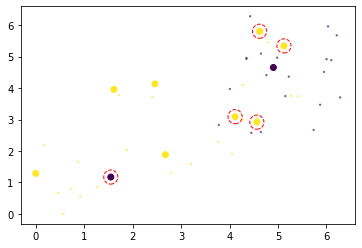

In [8]:
# plot the data
pred = qsvc.predict(test_dataset.features)

plt.scatter(train_dataset.features[:,0],train_dataset.features[:,1],c=train_dataset.labels,s=2,alpha=0.5)
plt.scatter(test_dataset.features[:,0],test_dataset.features[:,1],c=pred)
for x,y,yp in zip(test_dataset.features, test_dataset.labels, pred):
    if y!=yp:
        plt.scatter(x[0],x[1],facecolors='none', edgecolors='red', s=200, linewidth=1,linestyle='--')

# Visualizing the training process

From the callback data, we can plot how the loss evolves during the training process. We see it converges rapidly and reaches 100% test accuracy on this dataset with our choice of inputs.

We can also display the final kernel matrix, which is a measure of similarity between the training samples.

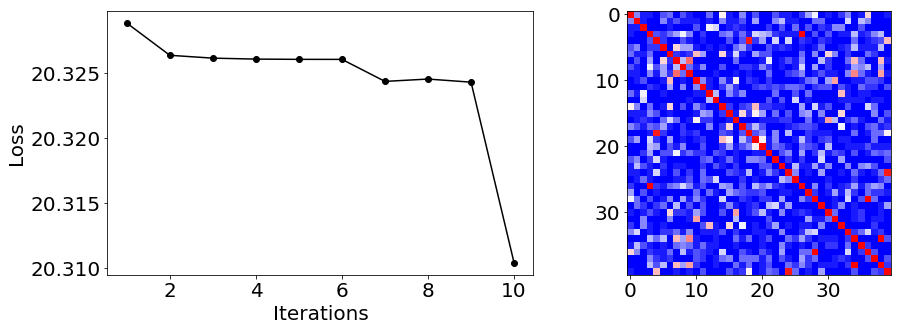

In [65]:
plot_data = cb_qkt.get_callback_data()  # callback data
K = optimized_kernel.evaluate(train_dataset.features)  # kernel matrix evaluated on the training samples

plt.rcParams["font.size"] = 20
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot([i + 1 for i in range(len(plot_data[0]))], np.array(plot_data[2]), c="k", marker="o")
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[1].imshow(K, cmap=cm.get_cmap("bwr", 20))
fig.tight_layout()
plt.show()